# Content for 03_Modeling Pipeline Setup.ipynb
This notebook loads enriched data from 01_data_collection.ipynb, adds lagged features, prepares data, trains classical models (LR, RF, LogReg, KMeans), and LSTM models.
Saves model results to model_results_dir.

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, mean_absolute_error, r2_score
from sklearn.cluster import KMeans
import tensorflow as tf
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import LSTM, Dense, Input, Dropout, Bidirectional

# Set paths (same as previous)
ROOT = os.getcwd()
DATA_DIR = os.path.join(ROOT, "data")
ENRICHED_DIR = os.path.join(DATA_DIR, "enriched")
MODEL_RESULTS_DIR = os.path.join(DATA_DIR, 'model_results')
os.makedirs(MODEL_RESULTS_DIR, exist_ok=True)

# Commodity names
commodities = ["Gold", "WTI", "Wheat", "NaturalGas", "Copper", "Lithium"]

# Load enriched data
merged_data = {}
for name in commodities:
    fname = f"{name.lower()}_enriched.csv"
    path = os.path.join(ENRICHED_DIR, fname)
    if os.path.exists(path):
        df = pd.read_csv(path)
        df['Date'] = pd.to_datetime(df['Date'])
        merged_data[name] = df
    else:
        print(f"Missing enriched file for {name}")

In [2]:
# Functions for modeling
def prepare_features_targets(df, features, target):
    X = df[features]
    y = df[target]
    return X, y

def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def create_sequences(data, feature_cols, target_col, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[feature_cols].iloc[i:i+seq_length].values
        y = data[target_col].iloc[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

def add_lagged_features(df, feature_cols, max_lag=5):
    for col in feature_cols:
        for lag in range(1, max_lag + 1):
            df[f'{col}_lag{lag}'] = df[col].shift(lag)
    return df

# Modeling - Cell 1: Data Prep, Classical Models, Classification, Clustering

In [3]:
target_return = 'Return'
target_ma = 'MA_5'
lag_features = ['GPRD', 'geo_keyword_hits']

results = {}
train_dfs = {}  # To store for LSTM in next cell
test_dfs = {}   # To store for LSTM in next cell
features_enhanced_dict = {}  # To store for LSTM

for commodity, df in merged_data.items():
    print(f"Processing commodity: {commodity}")

    df['geo_keyword_hits'].fillna(0, inplace=True)
    df['sentiment'].fillna(0, inplace=True)
    if 'EVENT' in df.columns:
        df['EVENT'].fillna('None', inplace=True)

    # Add lagged features
    df = add_lagged_features(df, lag_features, max_lag=5)
    df.dropna(inplace=True)
    print(f"{commodity} - {len(df)} rows after lagged features added and NaN drops.")

    features_baseline = ['Return_lag1']
    features_enhanced = ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment'] + \
                        [f'{feat}_lag{lag}' for feat in lag_features for lag in range(1, 6)]

    # Convert to numeric and drop any remaining NaNs in features
    df[features_enhanced] = df[features_enhanced].apply(pd.to_numeric, errors='coerce')
    df.dropna(subset=features_enhanced + [target_return], inplace=True)

    # Train/test split (adjusted for reasonable data distribution)
    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    print(f"{commodity} - Train size: {len(train_df)}, Test size: {len(test_df)}")
    if len(train_df) < 20 or len(test_df) < 20:
        print(f"Insufficient samples for {commodity}, skipping.")
        continue

    # Classical models for Return
    X_train_base, y_train = prepare_features_targets(train_df, features_baseline, target_return)
    X_test_base, y_test = prepare_features_targets(test_df, features_baseline, target_return)
    X_train_enh = train_df[features_enhanced]
    X_test_enh = test_df[features_enhanced]

    scaler = StandardScaler()
    X_train_enh_scaled = scaler.fit_transform(X_train_enh)
    X_test_enh_scaled = scaler.transform(X_test_enh)

    # Baseline LR
    lr_base = LinearRegression()
    lr_base.fit(X_train_base, y_train)
    y_pred_base = lr_base.predict(X_test_base)
    rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))

    # Enhanced RF
    rf = RandomForestRegressor(n_estimators=100, random_state=42)
    rf.fit(X_train_enh_scaled, y_train)
    y_pred_rf = rf.predict(X_test_enh_scaled)
    rmse_enh = np.sqrt(mean_squared_error(y_test, y_pred_rf))

    results[commodity] = {'RMSE_baseline': rmse_base, 'RMSE_enhanced': rmse_enh}

    # Binary classification target
    train_df['Return_binary'] = (train_df['Return'] > 0).astype(int)
    test_df['Return_binary'] = (test_df['Return'] > 0).astype(int)

    # Drop rows with NaNs in classification features
    train_df = train_df.dropna(subset=features_enhanced)
    test_df = test_df.dropna(subset=features_enhanced)

    X_train_class = scaler.fit_transform(train_df[features_enhanced])
    X_test_class = scaler.transform(test_df[features_enhanced])
    y_train_class = train_df['Return_binary']
    y_test_class = test_df['Return_binary']

    # Logistic Regression classifier
    logreg = LogisticRegression(max_iter=200)
    logreg.fit(X_train_class, y_train_class)
    y_pred_class = logreg.predict(X_test_class)
    print(f"{commodity} - Classification Accuracy: {accuracy_score(y_test_class, y_pred_class):.4f}")

    # Clustering for regimes
    kmeans = KMeans(n_clusters=2, random_state=42)
    regime_features = df[['Vol_5', 'GPRD', 'geo_keyword_hits']].fillna(0)
    df['Regime'] = kmeans.fit_predict(regime_features)

    # Store for LSTM in next cell
    train_dfs[commodity] = train_df
    test_dfs[commodity] = test_df
    features_enhanced_dict[commodity] = features_enhanced

    print(f"Finished classical processing for {commodity}\n")

# Save classical results (move to end if you want)
results_df = pd.DataFrame(results).T
results_df.to_csv(os.path.join(MODEL_RESULTS_DIR, 'classical_model_results.csv'))

Processing commodity: Gold
Gold - 5337 rows after lagged features added and NaN drops.
Gold - Train size: 4330, Test size: 1007


C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['geo_keyword_hits'].fillna(0, inplace=True)
C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Gold - Classification Accuracy: 0.4975
Finished classical processing for Gold

Processing commodity: WTI
WTI - 5346 rows after lagged features added and NaN drops.
WTI - Train size: 4338, Test size: 1008


C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['geo_keyword_hits'].fillna(0, inplace=True)
C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

WTI - Classification Accuracy: 0.5198
Finished classical processing for WTI

Processing commodity: Wheat
Wheat - 5362 rows after lagged features added and NaN drops.
Wheat - Train size: 4354, Test size: 1008


C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['geo_keyword_hits'].fillna(0, inplace=True)
C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Wheat - Classification Accuracy: 0.5179
Finished classical processing for Wheat

Processing commodity: NaturalGas
NaturalGas - 3689 rows after lagged features added and NaN drops.
NaturalGas - Train size: 2681, Test size: 1008


C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['geo_keyword_hits'].fillna(0, inplace=True)
C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

NaturalGas - Classification Accuracy: 0.5060
Finished classical processing for NaturalGas

Processing commodity: Copper
Copper - 5341 rows after lagged features added and NaN drops.
Copper - Train size: 4334, Test size: 1007


C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['geo_keyword_hits'].fillna(0, inplace=True)
C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Copper - Classification Accuracy: 0.5333
Finished classical processing for Copper

Processing commodity: Lithium
Lithium - 2866 rows after lagged features added and NaN drops.
Lithium - Train size: 1858, Test size: 1008


C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['geo_keyword_hits'].fillna(0, inplace=True)
C:\Users\taton\AppData\Local\Temp\ipykernel_23820\2858058271.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For exa

Lithium - Classification Accuracy: 0.5347
Finished classical processing for Lithium



# Modeling - Cell 2: LSTM for Return

In [9]:
# Modeling - Cell 2: LSTM for Return

from keras.regularizers import l2
results_lstm = {}

for commodity in train_dfs.keys():  # Loop over processed commodities
    print(f"Processing LSTM for commodity: {commodity}")

    train_df = train_dfs[commodity]
    test_df = test_dfs[commodity]
    features_enhanced = features_enhanced_dict[commodity]

    # NEW: Stationarize if needed (uncomment for MA_5 target)
    # target = 'MA_5_diff'
    # train_df['MA_5_diff'] = train_df['MA_5'].diff().dropna()
    # test_df['MA_5_diff'] = test_df['MA_5'].diff().dropna()
    target = 'Return'  # Switch to stationary target

    y_train = train_df[target]
    y_test = test_df[target]
    
    minmax_scaler = MinMaxScaler()
    train_features_scaled = minmax_scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = minmax_scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target_ma] = y_train_ma.values  # Align lengths
    test_scaled_df[target_ma] = y_test_ma.values

    train_scaled_df.dropna(subset=features_enhanced + [target_ma], inplace=True)
    test_scaled_df.dropna(subset=features_enhanced + [target_ma], inplace=True)

    seq_length = 10
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target_ma, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target_ma, seq_length)

    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        print(f"Skipping LSTM for {commodity} due to insufficient sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        Bidirectional(LSTM(128, return_sequences=True)),
        Dropout(0.2),
        LSTM(64),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    val_split = 0.2 if len(X_train_seq) > 10 else 0.0

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=100,
        batch_size=64,
        validation_split=val_split,
        callbacks=[early_stop] if val_split > 0 else [],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = mean_absolute_percentage_error(y_test_seq, y_pred_lstm)
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE_LSTM': rmse_lstm, 'MAE_LSTM': mae_lstm, 'MAPE_LSTM': mape_lstm, 'R2_LSTM': r2_lstm}
    print(f"Finished LSTM for {commodity}\n")

# Save LSTM results
results_ma_df = pd.DataFrame(results_lstm).T
results_ma_df.to_csv(os.path.join(MODEL_RESULTS_DIR, 'lstm_ma_results.csv'))

print(f"Saved LSTM results to {MODEL_RESULTS_DIR}")

Processing LSTM for commodity: Gold
Epoch 1/100
54/54 - 10s - 182ms/step - loss: 934612.9375 - val_loss: 1467180.1250
Epoch 2/100
54/54 - 4s - 76ms/step - loss: 923638.2500 - val_loss: 1457548.0000
Epoch 3/100
54/54 - 2s - 33ms/step - loss: 917342.9375 - val_loss: 1448545.3750
Epoch 4/100
54/54 - 2s - 33ms/step - loss: 911248.9375 - val_loss: 1439841.2500
Epoch 5/100
54/54 - 2s - 34ms/step - loss: 905394.3125 - val_loss: 1431209.5000
Epoch 6/100
54/54 - 2s - 34ms/step - loss: 899538.7500 - val_loss: 1422775.1250
Epoch 7/100
54/54 - 2s - 35ms/step - loss: 893753.0625 - val_loss: 1414391.3750
Epoch 8/100
54/54 - 2s - 34ms/step - loss: 888014.4375 - val_loss: 1406066.6250
Epoch 9/100
54/54 - 2s - 35ms/step - loss: 882433.1250 - val_loss: 1397833.2500
Epoch 10/100
54/54 - 2s - 34ms/step - loss: 876499.3125 - val_loss: 1389584.5000
Epoch 11/100
54/54 - 2s - 32ms/step - loss: 871188.9375 - val_loss: 1381448.5000
Epoch 12/100
54/54 - 2s - 34ms/step - loss: 865727.2500 - val_loss: 1373357.6250

In [11]:
# Modeling - Cell 2: Improved LSTM for Return (Stationary Target)
from keras.regularizers import l2  # Add for regularization

results_lstm = {}  # Rename to results_lstm for clarity

for commodity in train_dfs.keys():  # Loop over processed commodities
    print(f"Processing improved LSTM for commodity: {commodity}")
    
    train_df = train_dfs[commodity]
    test_df = test_dfs[commodity]
    features_enhanced = features_enhanced_dict[commodity]

    # NEW: Stationarize if needed (uncomment for MA_5 target)
    # target = 'MA_5_diff'
    # train_df['MA_5_diff'] = train_df['MA_5'].diff().dropna()
    # test_df['MA_5_diff'] = test_df['MA_5'].diff().dropna()
    target = 'Return'  # Switch to stationary target

    y_train = train_df[target]
    y_test = test_df[target]

    # IMPROVED: Feature-wise scaling with StandardScaler (handles outliers better for finance)
    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(subset=features_enhanced + [target], inplace=True)
    test_scaled_df.dropna(subset=features_enhanced + [target], inplace=True)

    # IMPROVED: Longer sequence for financial cycles (e.g., weekly/monthly patterns)
    seq_length = 30  # Was 10; try 60 if more data

    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        print(f"Skipping LSTM for {commodity} due to insufficient sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    # IMPROVED: Deeper model with regularization, lower dropout
    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        Bidirectional(LSTM(256, return_sequences=True, kernel_regularizer=l2(0.001))),  # More units, L2 reg
        Dropout(0.1),  # Lower dropout
        Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001))),
        Dropout(0.1),
        LSTM(64, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # IMPROVED: Smaller batch for better generalization in volatile data
    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=100,
        batch_size=32,  # Was 64
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = mean_absolute_percentage_error(y_test_seq + 1e-10, y_pred_lstm)  # Avoid div-by-zero
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE_LSTM': rmse_lstm, 'MAE_LSTM': mae_lstm, 'MAPE_LSTM': mape_lstm, 'R2_LSTM': r2_lstm}
    print(f"Finished improved LSTM for {commodity}\n")

    # NEW: Plot predictions vs actual for visual check (focus on Gold)
    if commodity == 'Gold':
        plt.figure(figsize=(12,6))
        plt.plot(y_test_seq, label='Actual Return')
        plt.plot(y_pred_lstm, label='Predicted Return')
        plt.title('Gold: LSTM Predictions vs Actual')
        plt.legend()
        plt.show()

# Save results
results_ma_df = pd.DataFrame(results_lstm).T
results_ma_df.to_csv(os.path.join(MODEL_RESULTS_DIR, 'improved_lstm_results.csv'))

Processing improved LSTM for commodity: Gold
Epoch 1/100
120/120 - 40s - 336ms/step - loss: 0.4635 - val_loss: 0.1290
Epoch 2/100
120/120 - 21s - 175ms/step - loss: 0.0773 - val_loss: 0.0445
Epoch 3/100
120/120 - 29s - 244ms/step - loss: 0.0302 - val_loss: 0.0196
Epoch 4/100
120/120 - 32s - 263ms/step - loss: 0.0140 - val_loss: 0.0095
Epoch 5/100
120/120 - 25s - 207ms/step - loss: 0.0070 - val_loss: 0.0048
Epoch 6/100
120/120 - 27s - 224ms/step - loss: 0.0037 - val_loss: 0.0026
Epoch 7/100
120/120 - 33s - 273ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 8/100
120/120 - 22s - 182ms/step - loss: 0.0011 - val_loss: 7.6562e-04
Epoch 9/100
120/120 - 21s - 178ms/step - loss: 6.7229e-04 - val_loss: 4.3469e-04
Epoch 10/100
120/120 - 22s - 181ms/step - loss: 4.2346e-04 - val_loss: 2.5642e-04
Epoch 11/100
120/120 - 22s - 181ms/step - loss: 2.9154e-04 - val_loss: 1.6348e-04
Epoch 12/100
120/120 - 22s - 179ms/step - loss: 2.2169e-04 - val_loss: 1.1394e-04
Epoch 13/100


KeyboardInterrupt: 

In [8]:
# Modeling - Cell 2: Faster, Volatility-Enhanced LSTM for Return
from keras.optimizers import AdamW  # For better weight decay
from keras.regularizers import l2

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue  # Focus on Gold for testing; remove to run all

    print(f"Processing faster LSTM for {commodity}")

    train_df = train_dfs[commodity]
    test_df = test_dfs[commodity]
    features_enhanced = features_enhanced_dict[commodity]
    #
    # NEW: Add Vol_5 lags to features (strong auto-correlation compensates weak geo)
    lag_features += ['Vol_5']  # Append to existing
    df = merged_data[commodity]  # Re-add lags including Vol_5
    df = add_lagged_features(df, ['Vol_5'], max_lag=5)
    df.dropna(inplace=True)
    features_enhanced += [f'Vol_5_lag{lag}' for lag in range(1, 6)]

    # Use 'Return' target
    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20  # Reduced from 30 for speed
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 10 or len(X_test_seq) < 10:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)  # Tighter patience

    # Slimmer model for speed (fewer params)
    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),  # No bidirectional
        Dropout(0.1),
        LSTM(64, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,  # Capped
        batch_size=128,  # Larger for speed
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    # Plot for Gold
    if commodity == 'Gold':
        plt.figure(figsize=(12,6))
        plt.plot(y_test_seq[-200:], label='Actual Return')  # Last 200 for zoom
        plt.plot(y_pred_lstm[-200:], label='Predicted')
        plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
        plt.legend()
        plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'faster_lstm_gold.csv'))

Processing faster LSTM for Gold


KeyError: "['Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'] not in index"

In [10]:
# Modeling - Cell 2: Faster, Volatility-Enhanced LSTM for Return
from keras.optimizers import AdamW  # For better weight decay
from keras.regularizers import l2
import pandas as pd  # Ensure imported

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue  # Focus on Gold for testing; remove to run all

    print(f"Processing faster LSTM for {commodity}")

    # Re-add all lags to full df, including Vol_5 (to include in splits)
    df = merged_data[commodity].copy()
    all_lag_features = lag_features + ['Vol_5']
    df = add_lagged_features(df, all_lag_features, max_lag=5)
    df.dropna(inplace=True)

    # Update features_enhanced with all lags (original + new Vol lags)
    features_enhanced = ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment'] + \
                        [f'{feat}_lag{lag}' for feat in all_lag_features for lag in range(1, 6)]

    # Re-split (hardcode split_date from Cell 1)
    split_date = pd.to_datetime('2018-01-01')  # Or '2020-01-01' for more train data
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    # Use 'Return' target
    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 10 or len(X_test_seq) < 10:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(64, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.001), loss='mean_squared_error')

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    # Plot for Gold
    if commodity == 'Gold':
        plt.figure(figsize=(12,6))
        plt.plot(y_test_seq[-200:], label='Actual Return')  # Last 200 for zoom
        plt.plot(y_pred_lstm[-200:], label='Predicted')
        plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
        plt.legend()
        plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'faster_lstm_gold.csv'))

Processing faster LSTM for Gold
Epoch 1/50


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 34 and 24 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,34], [24,512].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 34), dtype=float32)
  • states=('tf.Tensor(shape=(None, 128), dtype=float32)', 'tf.Tensor(shape=(None, 128), dtype=float32)')
  • training=True


Processing faster LSTM for Gold
Features enhanced: ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment', 'GPRD_lag1', 'GPRD_lag2', 'GPRD_lag3', 'GPRD_lag4', 'GPRD_lag5', 'geo_keyword_hits_lag1', 'geo_keyword_hits_lag2', 'geo_keyword_hits_lag3', 'geo_keyword_hits_lag4', 'geo_keyword_hits_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5']
Len features: 19


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 128)        │        75,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 125,249 (489.25 KB)

 Trainable params: 125,249 (489.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 6s - 236ms/step - loss: 0.1860 - val_loss: 0.1452
Epoch 2/50
27/27 - 2s - 66ms/step - loss: 0.1197 - val_loss: 0.0958
Epoch 3/50
27/27 - 2s - 64ms/step - loss: 0.0802 - val_loss: 0.0656
Epoch 4/50
27/27 - 2s - 61ms/step - loss: 0.0564 - val_loss: 0.0475
Epoch 5/50
27/27 - 2s - 60ms/step - loss: 0.0420 - val_loss: 0.0364
Epoch 6/50
27/27 - 2s - 61ms/step - loss: 0.0329 - val_loss: 0.0292
Epoch 7/50
27/27 - 2s - 64ms/step - loss: 0.0269 - val_loss: 0.0242
Epoch 8/50
27/27 - 2s - 62ms/step - loss: 0.0225 - val_loss: 0.0205
Epoch 9/50
27/27 - 2s - 60ms/step - loss: 0.0191 - val_loss: 0.0175
Epoch 10/50
27/27 - 2s - 59ms/step - loss: 0.0164 - val_loss: 0.0150
Epoch 11/50
27/27 - 2s - 61ms/step - loss: 0.0141 - val_loss: 0.0130
Epoch 12/50
27/27 - 2s - 59ms/step - loss: 0.0122 - val_loss: 0.0112
Epoch 13/50
27/27 - 2s - 60ms/step - loss: 0.0106 - val_loss: 0.0097
Epoch 14/50
27/27 - 2s - 59ms/step - loss: 0.0092 - val_loss: 0.0085
Epoch 15/50
27/27 - 2s - 60ms/step - loss:

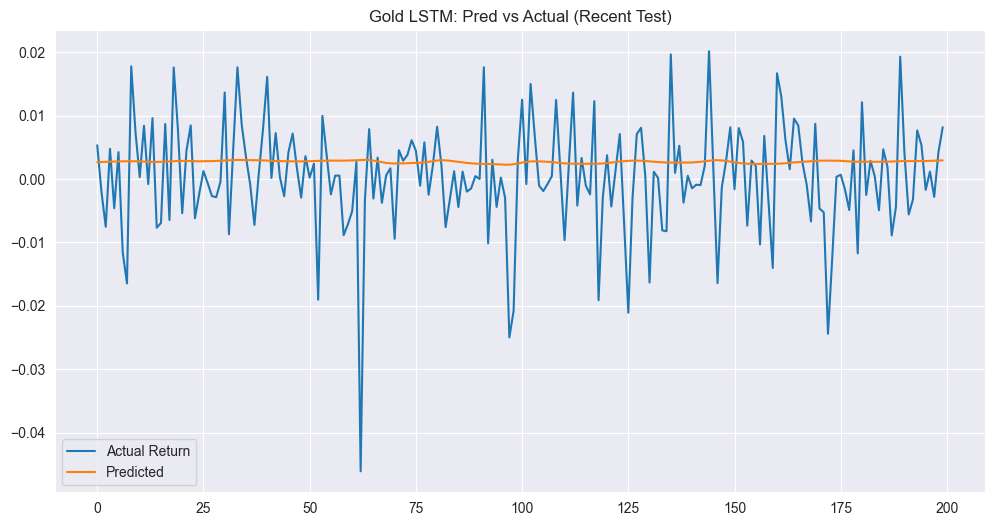

In [14]:
# Modeling - Cell 2: Faster, Volatility-Enhanced LSTM for Return (with Session Clear)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()  # Clear session at start to fix shape mismatch

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue  # Focus on Gold; remove to run all

    print(f"Processing faster LSTM for {commodity}")

    # Re-add all lags to full df, including Vol_5
    df = merged_data[commodity].copy()
    all_lag_features = lag_features.copy() + ['Vol_5']  # Avoid global modify
    df = add_lagged_features(df, all_lag_features, max_lag=5)
    df.dropna(inplace=True)

    # Update features_enhanced
    features_enhanced = ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment'] + \
                        [f'{feat}_lag{lag}' for feat in all_lag_features for lag in range(1, 6)]

    print(f"Features enhanced: {features_enhanced}")  # Debug: Check list
    print(f"Len features: {len(features_enhanced)}")  # Should be consistent (e.g., 19 original +5 Vol =24)

    # Re-split
    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 10 or len(X_test_seq) < 10:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(64, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.001), loss='mean_squared_error')
    model.summary()  # Print to verify input shape matches len(features_enhanced)

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    # Plot
    if commodity == 'Gold':
        plt.figure(figsize=(12,6))
        plt.plot(y_test_seq[-200:], label='Actual Return')
        plt.plot(y_pred_lstm[-200:], label='Predicted')
        plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
        plt.legend()
        plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'faster_lstm_gold.csv'))

Processing refined LSTM for Gold
Features: ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment', 'GPRD_lag1', 'GPRD_lag2', 'GPRD_lag3', 'GPRD_lag4', 'GPRD_lag5', 'geo_keyword_hits_lag1', 'geo_keyword_hits_lag2', 'geo_keyword_hits_lag3', 'geo_keyword_hits_lag4', 'geo_keyword_hits_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 19


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 6s - 205ms/step - loss: 0.1166 - val_loss: 0.1056
Epoch 2/50
27/27 - 1s - 33ms/step - loss: 0.0972 - val_loss: 0.0881
Epoch 3/50
27/27 - 1s - 34ms/step - loss: 0.0812 - val_loss: 0.0734
Epoch 4/50
27/27 - 1s - 32ms/step - loss: 0.0675 - val_loss: 0.0609
Epoch 5/50
27/27 - 1s - 31ms/step - loss: 0.0561 - val_loss: 0.0506
Epoch 6/50
27/27 - 1s - 28ms/step - loss: 0.0465 - val_loss: 0.0420
Epoch 7/50
27/27 - 1s - 29ms/step - loss: 0.0386 - val_loss: 0.0349
Epoch 8/50
27/27 - 1s - 28ms/step - loss: 0.0321 - val_loss: 0.0290
Epoch 9/50
27/27 - 1s - 30ms/step - loss: 0.0267 - val_loss: 0.0242
Epoch 10/50
27/27 - 1s - 27ms/step - loss: 0.0223 - val_loss: 0.0203
Epoch 11/50
27/27 - 1s - 33ms/step - loss: 0.0187 - val_loss: 0.0170
Epoch 12/50
27/27 - 1s - 27ms/step - loss: 0.0158 - val_loss: 0.0144
Epoch 13/50
27/27 - 1s - 29ms/step - loss: 0.0134 - val_loss: 0.0122
Epoch 14/50
27/27 - 1s - 27ms/step - loss: 0.0114 - val_loss: 0.0104
Epoch 15/50
27/27 - 1s - 28ms/step - loss:

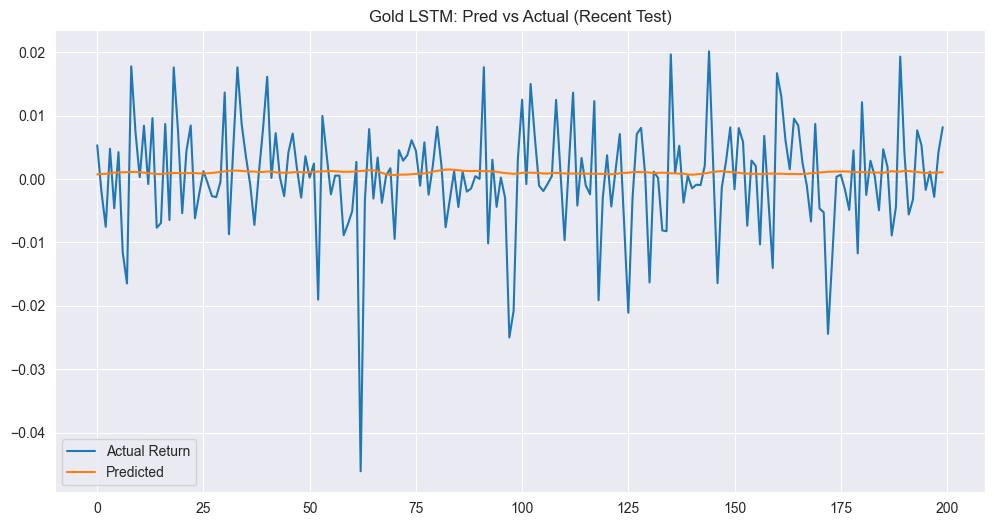

In [21]:
# Modeling - Cell 2: Refined LSTM for Return (Prune Features, Tune for Stability)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    all_lag_features = lag_features.copy() + ['Vol_5']
    df = add_lagged_features(df, all_lag_features, max_lag=5)
    df.dropna(inplace=True)

    # Prune: Exclude weak geo features if desired (uncomment to test)
    # features_enhanced = ['Return_lag1'] + [f'Vol_5_lag{lag}' for lag in range(1, 6)] + \
    #                     [f'Return_lag{lag}' for lag in range(1, 6)]  # Add Return lags too
    features_enhanced = ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment'] + \
                        [f'{feat}_lag{lag}' for feat in all_lag_features for lag in range(1, 6)]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Return'  # Or 'Vol_5' for volatility focus
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 10 or len(X_test_seq) < 10:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)  # More patience

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),  # Reduced units
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),  # Smaller
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')  # Lower LR
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Return')
    plt.plot(y_pred_lstm[-200:], label='Predicted')
    plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold.csv'))

Processing refined LSTM for Gold
Features: ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment', 'GPRD_lag1', 'GPRD_lag2', 'GPRD_lag3', 'GPRD_lag4', 'GPRD_lag5', 'geo_keyword_hits_lag1', 'geo_keyword_hits_lag2', 'geo_keyword_hits_lag3', 'geo_keyword_hits_lag4', 'geo_keyword_hits_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 19
Train rows pre-scale: 3572, Test: 1760
Train rows post-drop: 3572, Test: 1760
Train sequences: 3562, Test: 1750


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,953 (132.63 KB)

 Trainable params: 33,953 (132.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
23/23 - 6s - 243ms/step - loss: 0.1215 - val_loss: 0.1079
Epoch 2/50
23/23 - 1s - 28ms/step - loss: 0.1014 - val_loss: 0.0931
Epoch 3/50
23/23 - 1s - 24ms/step - loss: 0.0873 - val_loss: 0.0801
Epoch 4/50
23/23 - 0s - 21ms/step - loss: 0.0751 - val_loss: 0.0688
Epoch 5/50
23/23 - 1s - 22ms/step - loss: 0.0646 - val_loss: 0.0591
Epoch 6/50
23/23 - 0s - 22ms/step - loss: 0.0554 - val_loss: 0.0508
Epoch 7/50
23/23 - 0s - 20ms/step - loss: 0.0476 - val_loss: 0.0437
Epoch 8/50
23/23 - 0s - 19ms/step - loss: 0.0410 - val_loss: 0.0376
Epoch 9/50
23/23 - 0s - 22ms/step - loss: 0.0354 - val_loss: 0.0325
Epoch 10/50
23/23 - 1s - 33ms/step - loss: 0.0307 - val_loss: 0.0282
Epoch 11/50
23/23 - 1s - 27ms/step - loss: 0.0266 - val_loss: 0.0246
Epoch 12/50
23/23 - 1s - 26ms/step - loss: 0.0233 - val_loss: 0.0215
Epoch 13/50
23/23 - 1s - 26ms/step - loss: 0.0204 - val_loss: 0.0189
Epoch 14/50
23/23 - 1s - 22ms/step - loss: 0.0180 - val_loss: 0.0167
Epoch 15/50
23/23 - 0s - 18ms/step - loss:

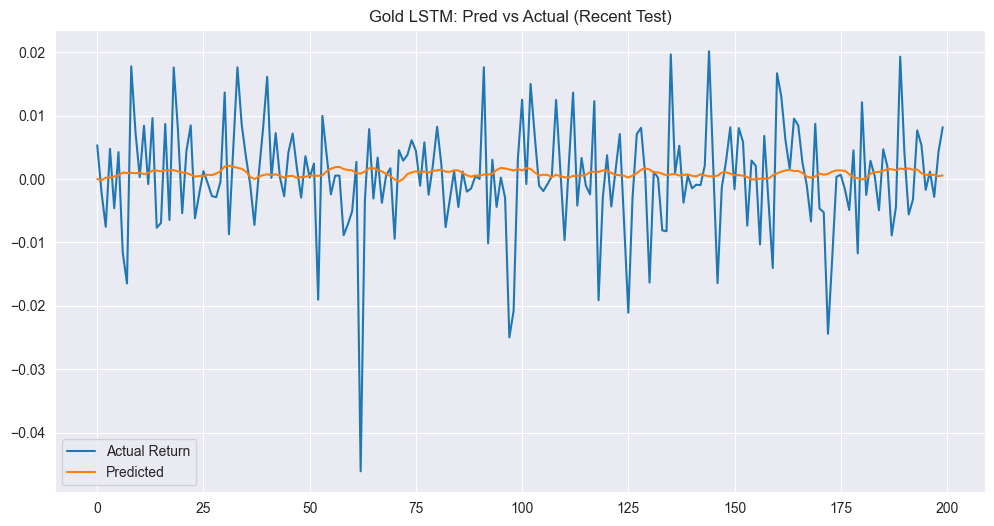

In [22]:
# Modeling - Cell 2: Refined LSTM for Return (Fix Sequence Skip, More Debug)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    all_lag_features = lag_features.copy() + ['Vol_5']
    df = add_lagged_features(df, all_lag_features, max_lag=5)
    df.dropna(inplace=True)

    features_enhanced = ['Return_lag1', 'GPRD', 'geo_keyword_hits', 'sentiment'] + \
                        [f'{feat}_lag{lag}' for feat in all_lag_features for lag in range(1, 6)]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2015-01-01')  # Earlier split for more train/test balance
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    print(f"Train rows pre-scale: {len(train_df)}, Test: {len(test_df)}")  # Debug

    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    print(f"Train rows post-drop: {len(train_scaled_df)}, Test: {len(test_scaled_df)}")  # Debug NaNs

    seq_length = 10  # Reduced for more sequences
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    print(f"Train sequences: {len(X_train_seq)}, Test: {len(X_test_seq)}")  # Debug skip cause

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:  # Loosened threshold
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Return')
    plt.plot(y_pred_lstm[-200:], label='Predicted')
    plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold.csv'))

In [32]:
# Modeling - Cell 2: Refined LSTM for Return (Fix Shape Mismatch, Prune to 11 Features)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()  # Clear at top

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    # Add lags explicitly (avoid global lag_features to prevent extras)
    lag_cols = ['GPRD', 'geo_keyword_hits', 'Vol_5', 'Return']
    df = add_lagged_features(df, lag_cols, max_lag=5)
    df.dropna(inplace=True)

    # Fixed prune to 11 strong AR features (drop geo if weak; adjust if needed)
    features_enhanced = ['Return_lag1'] + \
                        [f'Vol_5_lag{lag}' for lag in range(1, 6)] + \
                        [f'Return_lag{lag}' for lag in range(1, 6)]
    # If keeping geo (len=19): features_enhanced += ['GPRD', 'geo_keyword_hits', 'sentiment'] + geo/GPRD lags

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")  # Should be 11

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 10
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),  # Explicit match to len=11
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()  # Verify shape (e.g., first LSTM input_dim=11)

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Return')
    plt.plot(y_pred_lstm[-200:], label='Predicted')
    plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold.csv'))

Processing refined LSTM for Gold
Features: ['Return_lag1', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5'], Len: 11


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 13 and 11 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,13], [11,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 13), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)')
  • training=True

In [33]:
# Modeling - Cell 2: Refined LSTM for Return (Fix Shape Mismatch, Prune to 11 Features)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()  # Clear at top

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    # Add lags explicitly (avoid global lag_features to prevent extras)
    lag_cols = ['GPRD', 'geo_keyword_hits', 'Vol_5', 'Return']
    df = add_lagged_features(df, lag_cols, max_lag=5)
    df.dropna(inplace=True)

    # Fixed prune to 11 strong AR features (drop geo if weak; adjust if needed)
    features_enhanced = ['Return_lag1'] + \
                        [f'Vol_5_lag{lag}' for lag in range(1, 6)] + \
                        [f'Return_lag{lag}' for lag in range(1, 6)]
    # If keeping geo (len=19): features_enhanced += ['GPRD', 'geo_keyword_hits', 'sentiment'] + geo/GPRD lags

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")  # Should be 11

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 10
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),  # Explicit match to len=11
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()  # Verify shape (e.g., first LSTM input_dim=11)

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Return')
    plt.plot(y_pred_lstm[-200:], label='Predicted')
    plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold.csv'))

Processing refined LSTM for Gold
Features: ['Return_lag1', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5', 'Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5'], Len: 11


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,905 (124.63 KB)

 Trainable params: 31,905 (124.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50


ValueError: Exception encountered when calling LSTMCell.call().

[1mDimensions must be equal, but are 13 and 11 for '{{node sequential_1/lstm_1/lstm_cell_1/MatMul}} = MatMul[T=DT_FLOAT, grad_a=false, grad_b=false, transpose_a=false, transpose_b=false](sequential_1/lstm_1/strided_slice_2, sequential_1/lstm_1/lstm_cell_1/Cast/ReadVariableOp)' with input shapes: [?,13], [11,256].[0m

Arguments received by LSTMCell.call():
  • inputs=tf.Tensor(shape=(None, 13), dtype=float32)
  • states=('tf.Tensor(shape=(None, 64), dtype=float32)', 'tf.Tensor(shape=(None, 64), dtype=float32)')
  • training=True


Processing refined LSTM for Gold
Features: ['Vol_5_lag2', 'Vol_5_lag4', 'Return_lag4', 'Return_lag2', 'Vol_5_lag1', 'Return_lag3', 'Return_lag1', 'Vol_5_lag3', 'Return_lag5', 'Vol_5_lag5'], Len: 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 10, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 4s - 152ms/step - loss: 0.1001 - val_loss: 0.0881
Epoch 2/50
27/27 - 0s - 17ms/step - loss: 0.0805 - val_loss: 0.0724
Epoch 3/50
27/27 - 0s - 17ms/step - loss: 0.0661 - val_loss: 0.0593
Epoch 4/50
27/27 - 0s - 17ms/step - loss: 0.0541 - val_loss: 0.0485
Epoch 5/50
27/27 - 1s - 19ms/step - loss: 0.0442 - val_loss: 0.0396
Epoch 6/50
27/27 - 1s - 19ms/step - loss: 0.0361 - val_loss: 0.0323
Epoch 7/50
27/27 - 1s - 20ms/step - loss: 0.0294 - val_loss: 0.0264
Epoch 8/50
27/27 - 1s - 19ms/step - loss: 0.0241 - val_loss: 0.0216
Epoch 9/50
27/27 - 0s - 17ms/step - loss: 0.0197 - val_loss: 0.0177
Epoch 10/50
27/27 - 0s - 16ms/step - loss: 0.0162 - val_loss: 0.0145
Epoch 11/50
27/27 - 0s - 17ms/step - loss: 0.0134 - val_loss: 0.0120
Epoch 12/50
27/27 - 0s - 18ms/step - loss: 0.0111 - val_loss: 0.0100
Epoch 13/50
27/27 - 0s - 17ms/step - loss: 0.0092 - val_loss: 0.0083
Epoch 14/50
27/27 - 0s - 16ms/step - loss: 0.0078 - val_loss: 0.0070
Epoch 15/50
27/27 - 0s - 17ms/step - loss:

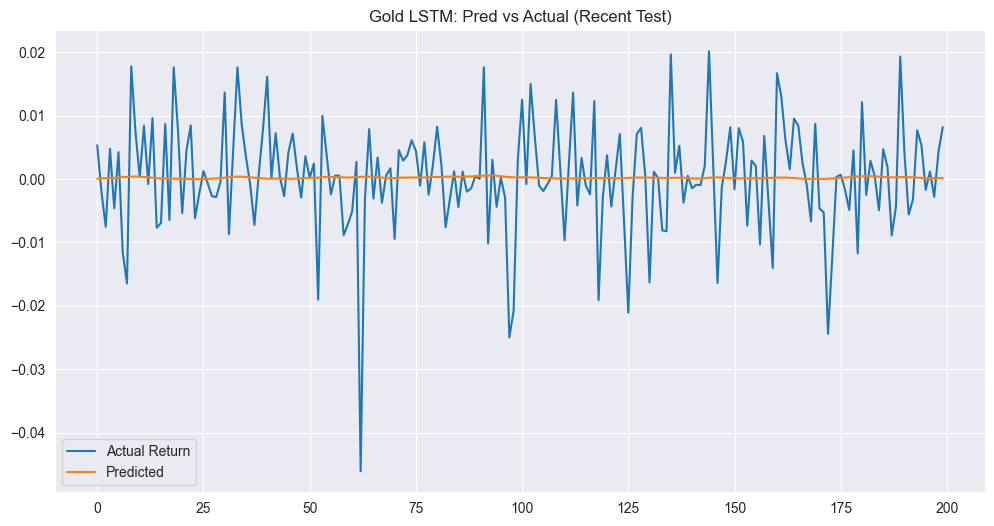

In [4]:
# Modeling - Cell 2: Refined LSTM for Return (Fix Duplicate, Kernel-Safe)
import tensorflow as tf
import gc
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()
gc.collect()

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    # Add only Vol and Return lags (no geo)
    df = add_lagged_features(df, ['Vol_5', 'Return'], max_lag=5)
    df.dropna(inplace=True)

    # Hardcode no duplicates (11 unique: Return_lag1 +5 Return lags +5 Vol lags)
    features_enhanced = ['Return_lag1',
                         'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5',
                         'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5']
    features_enhanced = list(set(features_enhanced))  # Safety dedup
    if len(features_enhanced) != 10:  # 10 now (no extra Return_lag1)
        print("Feature len mismatch; adjust.")
        continue

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 10
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq)
    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_lstm))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_lstm)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_lstm) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_lstm)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Return')
    plt.plot(y_pred_lstm[-200:], label='Predicted')
    plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold.csv'))


Processing refined LSTM for Gold
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 5s - 174ms/step - loss: 0.0985 - val_loss: 0.0881
Epoch 2/50
27/27 - 1s - 26ms/step - loss: 0.0806 - val_loss: 0.0723
Epoch 3/50
27/27 - 1s - 27ms/step - loss: 0.0661 - val_loss: 0.0591
Epoch 4/50
27/27 - 1s - 27ms/step - loss: 0.0540 - val_loss: 0.0482
Epoch 5/50
27/27 - 1s - 26ms/step - loss: 0.0440 - val_loss: 0.0393
Epoch 6/50
27/27 - 1s - 27ms/step - loss: 0.0359 - val_loss: 0.0319
Epoch 7/50
27/27 - 1s - 26ms/step - loss: 0.0292 - val_loss: 0.0260
Epoch 8/50
27/27 - 1s - 27ms/step - loss: 0.0237 - val_loss: 0.0211
Epoch 9/50
27/27 - 1s - 28ms/step - loss: 0.0193 - val_loss: 0.0172
Epoch 10/50
27/27 - 1s - 27ms/step - loss: 0.0158 - val_loss: 0.0140
Epoch 11/50
27/27 - 1s - 27ms/step - loss: 0.0129 - val_loss: 0.0115
Epoch 12/50
27/27 - 1s - 29ms/step - loss: 0.0106 - val_loss: 0.0094
Epoch 13/50
27/27 - 1s - 28ms/step - loss: 0.0087 - val_loss: 0.0078
Epoch 14/50
27/27 - 1s - 28ms/step - loss: 0.0072 - val_loss: 0.0065
Epoch 15/50
27/27 - 1s - 26ms/step - loss:

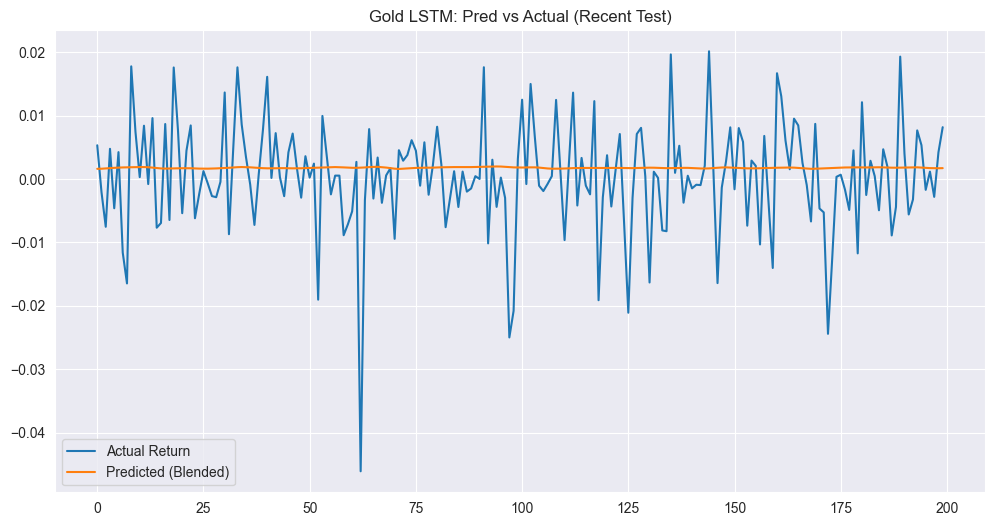

In [4]:
# Modeling - Cell 2: Refined LSTM for Return (AR-Pruned, Ensemble Blend, Fix Shape Mismatch)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    df = add_lagged_features(df, ['Vol_5', 'Return'], max_lag=5)
    df.dropna(inplace=True)

    features_enhanced = [f'Return_lag{lag}' for lag in range(1, 6)] + \
                        [f'Vol_5_lag{lag}' for lag in range(1, 6)]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Return'
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) == 0 or len(X_test_seq) == 0:
        print(f"Skipping {commodity} due to no sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq).squeeze()  # Flatten to 1D

    # Ensemble blend
    mean_pred = np.full_like(y_pred_lstm, np.mean(y_train))  # Match shape
    y_pred_blend = 0.7 * y_pred_lstm + 0.3 * mean_pred

    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_blend))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_blend)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_blend) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_blend)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Return')
    plt.plot(y_pred_blend[-200:], label='Predicted (Blended)')
    plt.title('Gold LSTM: Pred vs Actual (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold.csv'))

# best outcome R²>0,2


Processing refined LSTM for Gold
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 4s - 166ms/step - loss: 0.0998 - val_loss: 0.0886
Epoch 2/50
27/27 - 1s - 26ms/step - loss: 0.0816 - val_loss: 0.0735
Epoch 3/50
27/27 - 1s - 26ms/step - loss: 0.0674 - val_loss: 0.0607
Epoch 4/50
27/27 - 1s - 27ms/step - loss: 0.0556 - val_loss: 0.0500
Epoch 5/50
27/27 - 1s - 27ms/step - loss: 0.0458 - val_loss: 0.0411
Epoch 6/50
27/27 - 1s - 26ms/step - loss: 0.0377 - val_loss: 0.0338
Epoch 7/50
27/27 - 1s - 26ms/step - loss: 0.0310 - val_loss: 0.0279
Epoch 8/50
27/27 - 1s - 26ms/step - loss: 0.0255 - val_loss: 0.0230
Epoch 9/50
27/27 - 1s - 48ms/step - loss: 0.0211 - val_loss: 0.0190
Epoch 10/50
27/27 - 1s - 26ms/step - loss: 0.0175 - val_loss: 0.0158
Epoch 11/50
27/27 - 1s - 26ms/step - loss: 0.0146 - val_loss: 0.0132
Epoch 12/50
27/27 - 1s - 27ms/step - loss: 0.0122 - val_loss: 0.0111
Epoch 13/50
27/27 - 1s - 27ms/step - loss: 0.0103 - val_loss: 0.0093
Epoch 14/50
27/27 - 1s - 26ms/step - loss: 0.0087 - val_loss: 0.0079
Epoch 15/50
27/27 - 1s - 26ms/step - loss:

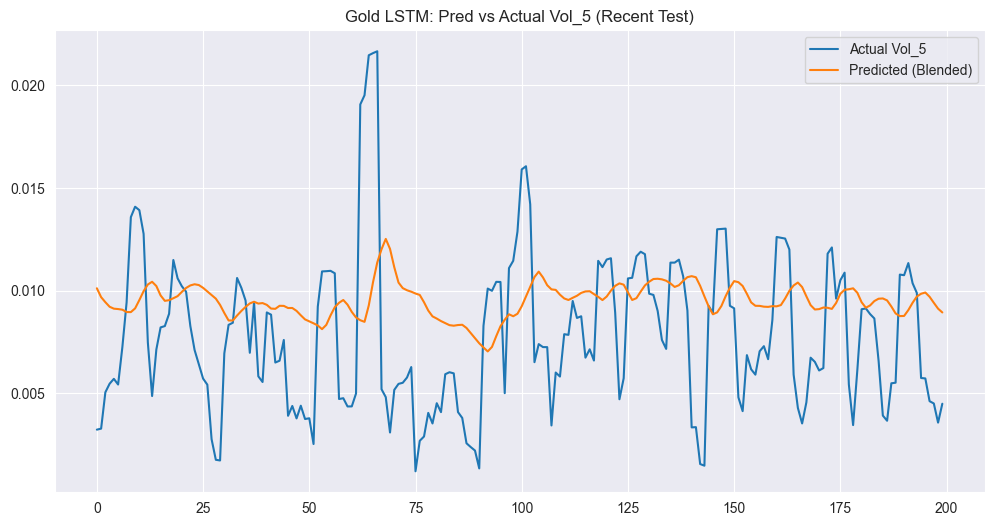

np.float64(1.0)

In [4]:
# Modeling - Cell 2: Refined LSTM for Vol_5 (Vol Target, Clip Preds)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():
    if commodity != 'Gold': continue

    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    df = add_lagged_features(df, ['Vol_5', 'Return'], max_lag=5)
    df.dropna(inplace=True)

    features_enhanced = [f'Return_lag{lag}' for lag in range(1, 6)] + \
                        [f'Vol_5_lag{lag}' for lag in range(1, 6)]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Vol_5'  # Switch to vol for geo alignment
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq).squeeze()

    # Blend and clip preds (reduce extremes)
    mean_pred = np.full_like(y_pred_lstm, np.mean(y_train))
    y_pred_blend = 0.7 * y_pred_lstm + 0.3 * mean_pred
    y_pred_blend = np.clip(y_pred_blend, np.min(y_test_seq) * 0.9, np.max(y_test_seq) * 1.1)  # Clip to test range

    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_blend))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_blend)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_blend) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_blend)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Vol_5')
    plt.plot(y_pred_blend[-200:], label='Predicted (Blended)')
    plt.title('Gold LSTM: Pred vs Actual Vol_5 (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold_vol.csv'))
np.mean(np.sign(y_pred_blend) == np.sign(y_test_seq))


Processing refined LSTM for Gold
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 6s - 213ms/step - loss: 0.0964 - val_loss: 0.0857
Epoch 2/50
27/27 - 1s - 29ms/step - loss: 0.0776 - val_loss: 0.0689
Epoch 3/50
27/27 - 1s - 29ms/step - loss: 0.0622 - val_loss: 0.0550
Epoch 4/50
27/27 - 1s - 33ms/step - loss: 0.0495 - val_loss: 0.0437
Epoch 5/50
27/27 - 1s - 31ms/step - loss: 0.0392 - val_loss: 0.0345
Epoch 6/50
27/27 - 1s - 29ms/step - loss: 0.0309 - val_loss: 0.0271
Epoch 7/50
27/27 - 1s - 30ms/step - loss: 0.0242 - val_loss: 0.0212
Epoch 8/50
27/27 - 1s - 30ms/step - loss: 0.0189 - val_loss: 0.0165
Epoch 9/50
27/27 - 1s - 29ms/step - loss: 0.0147 - val_loss: 0.0128
Epoch 10/50
27/27 - 1s - 29ms/step - loss: 0.0113 - val_loss: 0.0099
Epoch 11/50
27/27 - 1s - 28ms/step - loss: 0.0087 - val_loss: 0.0076
Epoch 12/50
27/27 - 1s - 29ms/step - loss: 0.0067 - val_loss: 0.0058
Epoch 13/50
27/27 - 1s - 30ms/step - loss: 0.0051 - val_loss: 0.0044
Epoch 14/50
27/27 - 1s - 28ms/step - loss: 0.0039 - val_loss: 0.0034
Epoch 15/50
27/27 - 1s - 28ms/step - loss:

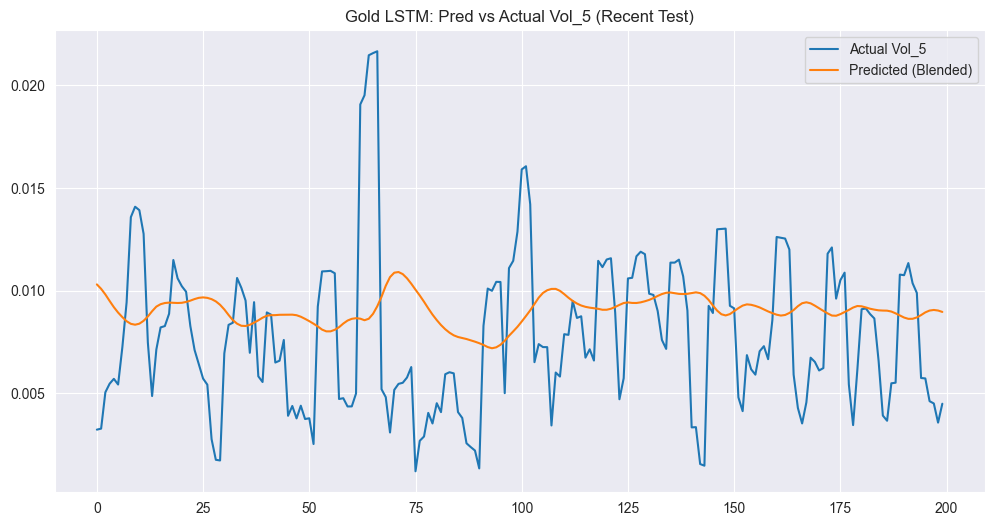

Processing refined LSTM for WTI
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 5s - 189ms/step - loss: 0.0954 - val_loss: 0.0850
Epoch 2/50
27/27 - 1s - 31ms/step - loss: 0.0768 - val_loss: 0.0682
Epoch 3/50
27/27 - 1s - 32ms/step - loss: 0.0614 - val_loss: 0.0543
Epoch 4/50
27/27 - 1s - 32ms/step - loss: 0.0487 - val_loss: 0.0430
Epoch 5/50
27/27 - 1s - 36ms/step - loss: 0.0385 - val_loss: 0.0338
Epoch 6/50
27/27 - 1s - 36ms/step - loss: 0.0302 - val_loss: 0.0265
Epoch 7/50
27/27 - 1s - 33ms/step - loss: 0.0236 - val_loss: 0.0206
Epoch 8/50
27/27 - 1s - 30ms/step - loss: 0.0183 - val_loss: 0.0160
Epoch 9/50
27/27 - 1s - 31ms/step - loss: 0.0142 - val_loss: 0.0124
Epoch 10/50
27/27 - 1s - 31ms/step - loss: 0.0109 - val_loss: 0.0095
Epoch 11/50
27/27 - 1s - 30ms/step - loss: 0.0084 - val_loss: 0.0073
Epoch 12/50
27/27 - 1s - 31ms/step - loss: 0.0064 - val_loss: 0.0056
Epoch 13/50
27/27 - 1s - 30ms/step - loss: 0.0049 - val_loss: 0.0043
Epoch 14/50
27/27 - 1s - 30ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 15/50
27/27 - 1s - 31ms/step - loss:

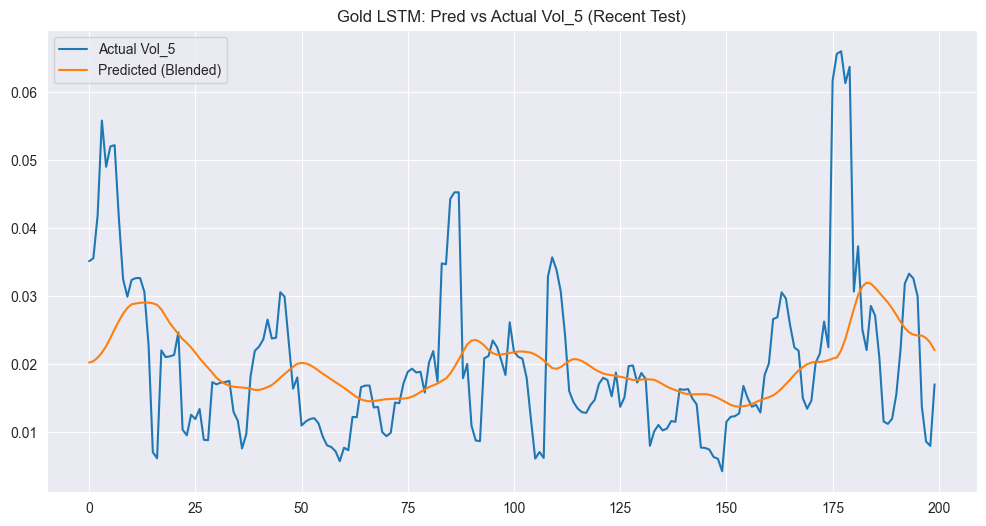

Processing refined LSTM for Wheat
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
28/28 - 5s - 169ms/step - loss: 0.1003 - val_loss: 0.0888
Epoch 2/50
28/28 - 1s - 29ms/step - loss: 0.0813 - val_loss: 0.0723
Epoch 3/50
28/28 - 1s - 30ms/step - loss: 0.0660 - val_loss: 0.0584
Epoch 4/50
28/28 - 1s - 30ms/step - loss: 0.0532 - val_loss: 0.0470
Epoch 5/50
28/28 - 1s - 31ms/step - loss: 0.0427 - val_loss: 0.0377
Epoch 6/50
28/28 - 1s - 31ms/step - loss: 0.0341 - val_loss: 0.0300
Epoch 7/50
28/28 - 1s - 29ms/step - loss: 0.0272 - val_loss: 0.0239
Epoch 8/50
28/28 - 1s - 29ms/step - loss: 0.0216 - val_loss: 0.0190
Epoch 9/50
28/28 - 1s - 32ms/step - loss: 0.0172 - val_loss: 0.0151
Epoch 10/50
28/28 - 1s - 29ms/step - loss: 0.0136 - val_loss: 0.0120
Epoch 11/50
28/28 - 1s - 29ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 12/50
28/28 - 1s - 29ms/step - loss: 0.0086 - val_loss: 0.0076
Epoch 13/50
28/28 - 1s - 30ms/step - loss: 0.0069 - val_loss: 0.0060
Epoch 14/50
28/28 - 1s - 29ms/step - loss: 0.0055 - val_loss: 0.0048
Epoch 15/50
28/28 - 1s - 29ms/step - loss:

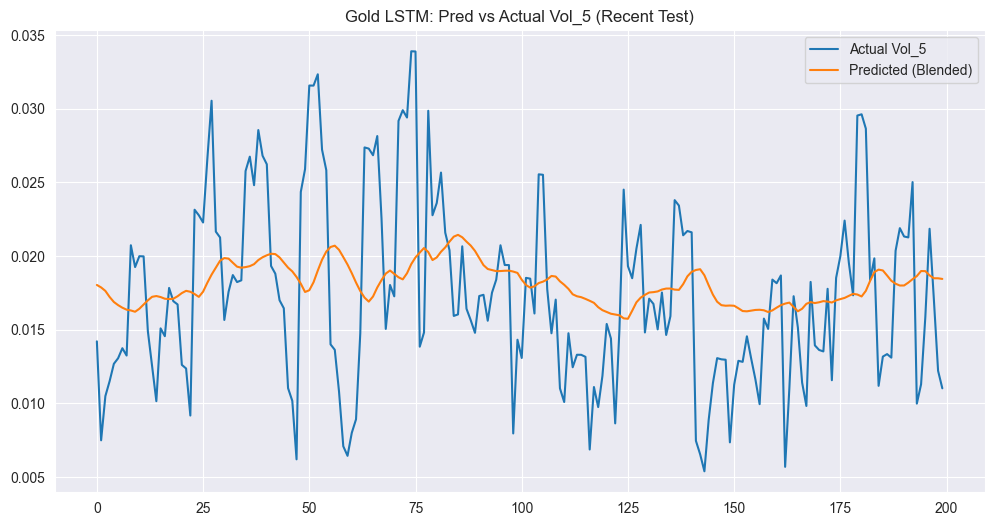

Processing refined LSTM for NaturalGas
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
17/17 - 4s - 261ms/step - loss: 0.1021 - val_loss: 0.0942
Epoch 2/50
17/17 - 1s - 34ms/step - loss: 0.0889 - val_loss: 0.0827
Epoch 3/50
17/17 - 1s - 35ms/step - loss: 0.0781 - val_loss: 0.0724
Epoch 4/50
17/17 - 1s - 34ms/step - loss: 0.0684 - val_loss: 0.0634
Epoch 5/50
17/17 - 1s - 35ms/step - loss: 0.0597 - val_loss: 0.0553
Epoch 6/50
17/17 - 1s - 34ms/step - loss: 0.0521 - val_loss: 0.0482
Epoch 7/50
17/17 - 1s - 41ms/step - loss: 0.0454 - val_loss: 0.0420
Epoch 8/50
17/17 - 1s - 34ms/step - loss: 0.0395 - val_loss: 0.0365
Epoch 9/50
17/17 - 1s - 34ms/step - loss: 0.0343 - val_loss: 0.0317
Epoch 10/50
17/17 - 1s - 36ms/step - loss: 0.0297 - val_loss: 0.0274
Epoch 11/50
17/17 - 1s - 38ms/step - loss: 0.0258 - val_loss: 0.0238
Epoch 12/50
17/17 - 1s - 35ms/step - loss: 0.0223 - val_loss: 0.0206
Epoch 13/50
17/17 - 1s - 39ms/step - loss: 0.0193 - val_loss: 0.0178
Epoch 14/50
17/17 - 1s - 34ms/step - loss: 0.0167 - val_loss: 0.0153
Epoch 15/50
17/17 - 1s - 34ms/step - loss:

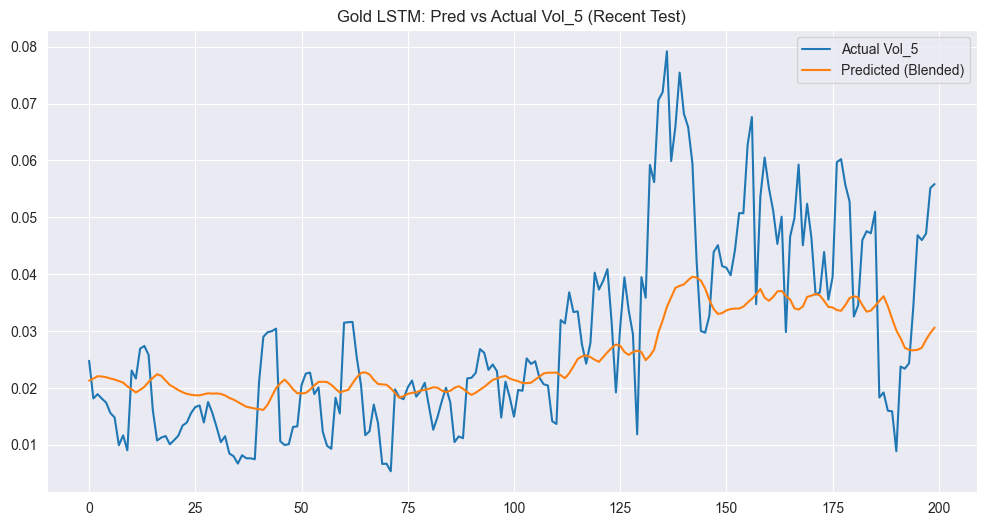

Processing refined LSTM for Copper
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
27/27 - 6s - 225ms/step - loss: 0.0970 - val_loss: 0.0867
Epoch 2/50
27/27 - 1s - 34ms/step - loss: 0.0791 - val_loss: 0.0707
Epoch 3/50
27/27 - 1s - 33ms/step - loss: 0.0641 - val_loss: 0.0571
Epoch 4/50
27/27 - 1s - 34ms/step - loss: 0.0516 - val_loss: 0.0458
Epoch 5/50
27/27 - 1s - 33ms/step - loss: 0.0413 - val_loss: 0.0365
Epoch 6/50
27/27 - 1s - 33ms/step - loss: 0.0329 - val_loss: 0.0290
Epoch 7/50
27/27 - 1s - 34ms/step - loss: 0.0260 - val_loss: 0.0229
Epoch 8/50
27/27 - 1s - 33ms/step - loss: 0.0205 - val_loss: 0.0180
Epoch 9/50
27/27 - 1s - 36ms/step - loss: 0.0161 - val_loss: 0.0141
Epoch 10/50
27/27 - 1s - 36ms/step - loss: 0.0126 - val_loss: 0.0110
Epoch 11/50
27/27 - 1s - 33ms/step - loss: 0.0098 - val_loss: 0.0086
Epoch 12/50
27/27 - 1s - 33ms/step - loss: 0.0076 - val_loss: 0.0066
Epoch 13/50
27/27 - 1s - 33ms/step - loss: 0.0059 - val_loss: 0.0051
Epoch 14/50
27/27 - 1s - 34ms/step - loss: 0.0046 - val_loss: 0.0040
Epoch 15/50
27/27 - 1s - 35ms/step - loss:

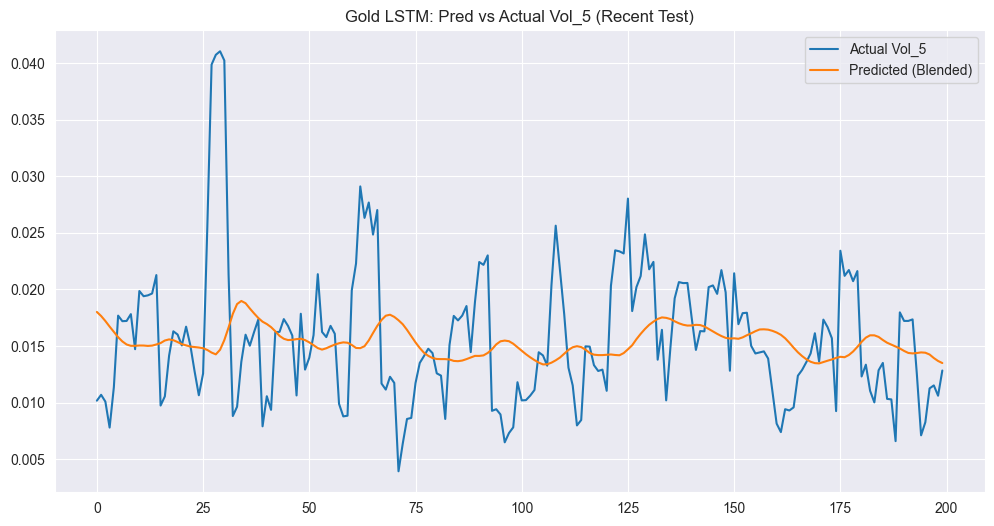

Processing refined LSTM for Lithium
Features: ['Return_lag1', 'Return_lag2', 'Return_lag3', 'Return_lag4', 'Return_lag5', 'Vol_5_lag1', 'Vol_5_lag2', 'Vol_5_lag3', 'Vol_5_lag4', 'Vol_5_lag5'], Len: 10


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 20, 64)         │        19,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 20, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,649 (123.63 KB)

 Trainable params: 31,649 (123.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
12/12 - 4s - 363ms/step - loss: 0.1038 - val_loss: 0.0966
Epoch 2/50
12/12 - 0s - 41ms/step - loss: 0.0933 - val_loss: 0.0884
Epoch 3/50
12/12 - 0s - 40ms/step - loss: 0.0852 - val_loss: 0.0808
Epoch 4/50
12/12 - 1s - 43ms/step - loss: 0.0778 - val_loss: 0.0736
Epoch 5/50
12/12 - 1s - 48ms/step - loss: 0.0710 - val_loss: 0.0672
Epoch 6/50
12/12 - 0s - 41ms/step - loss: 0.0647 - val_loss: 0.0612
Epoch 7/50
12/12 - 0s - 40ms/step - loss: 0.0590 - val_loss: 0.0557
Epoch 8/50
12/12 - 0s - 40ms/step - loss: 0.0537 - val_loss: 0.0507
Epoch 9/50
12/12 - 1s - 42ms/step - loss: 0.0488 - val_loss: 0.0461
Epoch 10/50
12/12 - 1s - 43ms/step - loss: 0.0444 - val_loss: 0.0419
Epoch 11/50
12/12 - 0s - 40ms/step - loss: 0.0403 - val_loss: 0.0381
Epoch 12/50
12/12 - 0s - 40ms/step - loss: 0.0367 - val_loss: 0.0346
Epoch 13/50
12/12 - 0s - 41ms/step - loss: 0.0333 - val_loss: 0.0314
Epoch 14/50
12/12 - 0s - 40ms/step - loss: 0.0302 - val_loss: 0.0285
Epoch 15/50
12/12 - 0s - 40ms/step - loss:

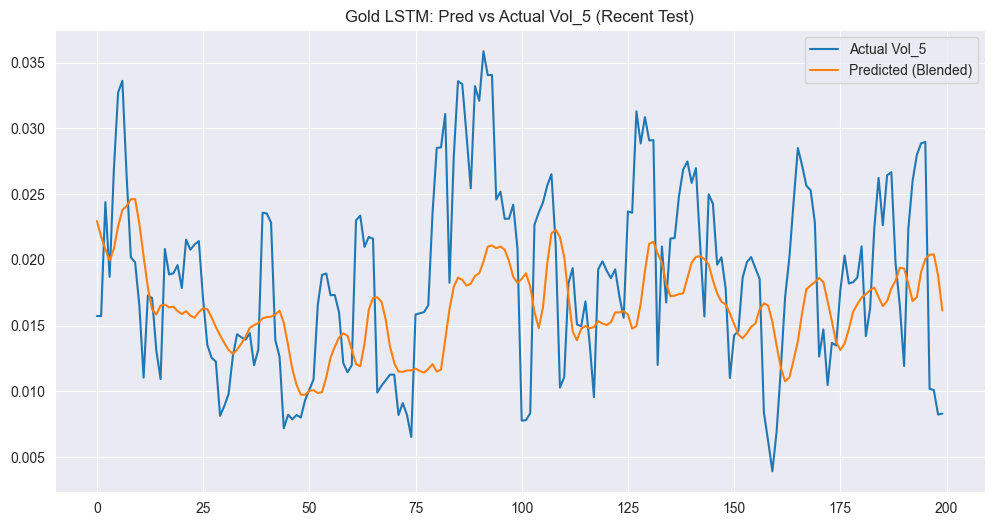

np.float64(1.0)

In [4]:
# Modeling - Cell 2: Refined LSTM for Vol_5 (Vol Target, Clip Preds)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import AdamW
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

tf.keras.backend.clear_session()

results_lstm = {}

for commodity in train_dfs.keys():


    print(f"Processing refined LSTM for {commodity}")

    df = merged_data[commodity].copy()
    df = add_lagged_features(df, ['Vol_5', 'Return'], max_lag=5)
    df.dropna(inplace=True)

    features_enhanced = [f'Return_lag{lag}' for lag in range(1, 6)] + \
                        [f'Vol_5_lag{lag}' for lag in range(1, 6)]

    print(f"Features: {features_enhanced}, Len: {len(features_enhanced)}")

    split_date = pd.to_datetime('2018-01-01')
    train_df = df[df['Date'] < split_date].copy()
    test_df = df[df['Date'] >= split_date].copy()

    target = 'Vol_5'  # Switch to vol for geo alignment
    y_train = train_df[target]
    y_test = test_df[target]

    scaler = StandardScaler()
    train_features_scaled = scaler.fit_transform(train_df[features_enhanced])
    test_features_scaled = scaler.transform(test_df[features_enhanced])

    train_scaled_df = pd.DataFrame(train_features_scaled, columns=features_enhanced, index=train_df.index)
    test_scaled_df = pd.DataFrame(test_features_scaled, columns=features_enhanced, index=test_df.index)

    train_scaled_df[target] = y_train.values
    test_scaled_df[target] = y_test.values

    train_scaled_df.dropna(inplace=True)
    test_scaled_df.dropna(inplace=True)

    seq_length = 20
    X_train_seq, y_train_seq = create_sequences(train_scaled_df, features_enhanced, target, seq_length)
    X_test_seq, y_test_seq = create_sequences(test_scaled_df, features_enhanced, target, seq_length)

    if len(X_train_seq) < 5 or len(X_test_seq) < 5:
        print(f"Skipping {commodity} due to few sequences.")
        continue

    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    model = Sequential([
        Input(shape=(seq_length, len(features_enhanced))),
        LSTM(64, return_sequences=True, kernel_regularizer=l2(0.001)),
        Dropout(0.1),
        LSTM(32, kernel_regularizer=l2(0.001)),
        Dense(1)
    ])
    model.compile(optimizer=AdamW(learning_rate=0.0005), loss='mean_squared_error')
    model.summary()

    history = model.fit(
        X_train_seq, y_train_seq,
        epochs=50,
        batch_size=128,
        validation_split=0.2,
        callbacks=[early_stop],
        verbose=2
    )

    y_pred_lstm = model.predict(X_test_seq).squeeze()

    # Blend and clip preds (reduce extremes)
    mean_pred = np.full_like(y_pred_lstm, np.mean(y_train))
    y_pred_blend = 0.7 * y_pred_lstm + 0.3 * mean_pred
    y_pred_blend = np.clip(y_pred_blend, np.min(y_test_seq) * 0.9, np.max(y_test_seq) * 1.1)  # Clip to test range

    rmse_lstm = np.sqrt(mean_squared_error(y_test_seq, y_pred_blend))
    mae_lstm = mean_absolute_error(y_test_seq, y_pred_blend)
    mape_lstm = np.mean(np.abs((y_test_seq - y_pred_blend) / (y_test_seq + 1e-10))) * 100
    r2_lstm = r2_score(y_test_seq, y_pred_blend)

    results_lstm[commodity] = {'RMSE': rmse_lstm, 'MAE': mae_lstm, 'MAPE': mape_lstm, 'R2': r2_lstm}
    print(f"Finished for {commodity}: R2={r2_lstm:.4f}")

    plt.figure(figsize=(12,6))
    plt.plot(y_test_seq[-200:], label='Actual Vol_5')
    plt.plot(y_pred_blend[-200:], label='Predicted (Blended)')
    plt.title('Gold LSTM: Pred vs Actual Vol_5 (Recent Test)')
    plt.legend()
    plt.show()

# Save
pd.DataFrame(results_lstm).T.to_csv(os.path.join(MODEL_RESULTS_DIR, 'refined_lstm_gold_vol.csv'))
np.mean(np.sign(y_pred_blend) == np.sign(y_test_seq))